In [ ]:
import numpy as np
import datetime as dt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
!pip install openpyxl

from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
file_path = '/content/drive/MyDrive//Colab Notebooks/data/Online_Retail_Data/online_retail_II.xlsx'
retaildata_df = pd.read_excel(file_path)
retaildata_df.head()

Mounted at /content/drive


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


**Data Quality Check**


In [ ]:
retaildata_df.shape

(525461, 8)

In [ ]:
retaildata_df.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

In [ ]:
retaildata_df.describe()

,Quantity,Price,Customer ID
count,525461.000000,525461.000000,417534.000000
mean,10.337667,4.688834,15360.645478
std,107.424110,146.126914,1680.811316
min,-9600.000000,-53594.360000,12346.000000
25%,1.000000,1.250000,13983.000000
50%,3.000000,2.100000,15311.000000
75%,10.000000,4.210000,16799.000000
max,19152.000000,25111.090000,18287.000000


By looking at the Price and Quantity features, it is observed negative values which idicates returned products. Also comparing the 75% with max values presence of outliers in the data, is clearly observed.

In [ ]:
print('A total of '+ str(retaildata_df.Invoice.nunique()) +' unique invoices were generated.')
print('We have '+ str(retaildata_df.StockCode.nunique()) +' unique products sold online.')

# We are renaming the CustomerID for conveniency
retaildata_df = retaildata_df.rename(columns={'Customer ID':'CustomerID'})

print('We have '+ str(retaildata_df.CustomerID.nunique()) +' unique Customers in our dataset.')
print('We have customers spread across '+ str(retaildata_df.Country.nunique()) +' countries. ')

A total of 28816 unique invoices were generated.
We have 4632 unique products sold online.
We have 4383 unique Customers in our dataset.
We have customers spread across 40 countries. 


**Data Preprocessing**

In [ ]:
#Checking for null values
retaildata_df.isnull().sum().sort_values(ascending=False)

CustomerID     107927
Description      2928
Invoice             0
StockCode           0
Quantity            0
InvoiceDate         0
Price               0
Country             0
dtype: int64

<Axes: >

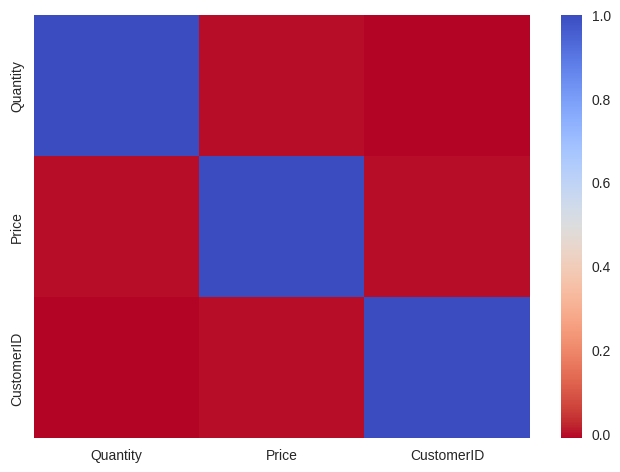

In [ ]:
#Correlation check
corrDf = retaildata_df.corr()
sns.heatmap(corrDf,
        xticklabels=corrDf.columns,
        yticklabels=corrDf.columns, cmap='coolwarm_r')

In [ ]:
#Dropping Negative Values
retaildata_df = retaildata_df[(retaildata_df['Quantity']>0) & (retaildata_df['Price']>0)]
retaildata_df.describe()

,Quantity,Price,CustomerID
count,511566.000000,511566.000000,407664.000000
mean,11.400150,4.252563,15368.592598
std,86.761177,63.664629,1679.762138
min,1.000000,0.001000,12346.000000
25%,1.000000,1.250000,13997.000000
50%,3.000000,2.100000,15321.000000
75%,10.000000,4.210000,16812.000000
max,19152.000000,25111.090000,18287.000000


In [ ]:
retaildata_df.shape

(511566, 8)

In [ ]:
#Removing duplicates
retaildata_df=retaildata_df.drop_duplicates()
retaildata_df.shape

(504731, 8)

**RFM Analysis**





The first step in building an RFM model is to assign Recency, Frequency and Monetary values to each customer. So, RFM analysis can be carried out only on customers who have customerID.

In [ ]:
retaildata_df.InvoiceDate.max()

Timestamp('2010-12-09 20:01:00')

In [ ]:
# Create a column Amount(Total cost)
retaildata_df.loc[:, 'Amount'] = retaildata_df['Quantity'] * retaildata_df['Price']

pin_date = dt.datetime(2010, 12,10)

rfm = retaildata_df.groupby('CustomerID').agg({'InvoiceDate': lambda InvoiceDate: (pin_date - InvoiceDate.max()).days,
                                     'Invoice': lambda Invoice: Invoice.nunique(),
                                     'Amount': lambda Amount: Amount.sum()})
rfm.columns = ['recency', 'frequency', 'monetary']
rfm.head()


<ipython-input-13-562edb880248>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retaildata_df.loc[:, 'Amount'] = retaildata_df['Quantity'] * retaildata_df['Price']


,recency,frequency,monetary
CustomerID,,,
12346.0,164,11,372.86
12347.0,2,2,1323.32
12348.0,73,1,222.16
12349.0,42,3,2671.14
12351.0,10,1,300.93


In [ ]:

rfm = rfm[rfm["monetary"] > 0]
rfm.head()

,recency,frequency,monetary
CustomerID,,,
12346.0,164,11,372.86
12347.0,2,2,1323.32
12348.0,73,1,222.16
12349.0,42,3,2671.14
12351.0,10,1,300.93


**RFM Scoring according to Percentile Ranking Approach**

In [ ]:
#Split into four segments using quantiles
quantiles = rfm.quantile(q=[0.25,0.5,0.75])

# Define function to score recency, frequency, and monetary value
#Functions to create R, F and M segments
def RScoring(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

def FnMScoring(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

#Calculate Add R, F and M segment value columns in the existing dataset to show R, F and M segment values
rfm['R_percentile'] = rfm['recency'].apply(RScoring, args=('recency',quantiles,))
rfm['F_percentile'] = rfm['frequency'].apply(FnMScoring, args=('frequency',quantiles,))
rfm['M_percentile'] = rfm['monetary'].apply(FnMScoring, args=('monetary',quantiles,))


#Calculate RFM group
rfm['RFMGroup_Percentile'] = rfm.R_percentile.map(str) + rfm.F_percentile.map(str) + rfm.M_percentile.map(str)


# Combine the RFM scores into a single column
rfm['RFM_Percentile'] = rfm[['R_percentile', 'F_percentile', 'M_percentile']].sum(axis=1)


# Combine RFM scores into a single column
rfm

,recency,frequency,monetary,R_percentile,F_percentile,M_percentile,RFMGroup_Percentile,RFM_Percentile
CustomerID,,,,,,,,
12346.0,164,11,372.86,4,1,3,413,8
12347.0,2,2,1323.32,1,3,2,132,6
12348.0,73,1,222.16,3,4,4,344,11
12349.0,42,3,2671.14,2,2,1,221,5
12351.0,10,1,300.93,1,4,4,144,9
...,...,...,...,...,...,...,...,...
18283.0,17,6,619.37,1,1,3,113,5
18284.0,66,1,461.68,3,4,3,343,10
18285.0,295,1,427.00,4,4,3,443,11


**RFM Scoring according to Equal Interval Approach**

In [ ]:

# Create the RFM score for each customer using the equal interval method
rfm['R_EqualE'] = pd.cut(rfm['recency'], bins=[-np.inf, 25, 50, 75, np.inf], labels=[1, 2, 3, 4])
rfm['F_EqualE'] = pd.cut(rfm['frequency'], bins=[-np.inf, 25, 50, 75, np.inf], labels=[1, 2, 3, 4])
rfm['M_EqualE'] = pd.cut(rfm['monetary'], bins=[-np.inf, 25, 50, 75, np.inf], labels=[1, 2, 3, 4])

# Calculate RFM group
rfm['RFMGroup_EqualInterval'] = rfm['R_EqualE'].astype(str) + rfm['F_EqualE'].astype(str) + rfm['M_EqualE'].astype(str)

# Calculate RFM score by summing the individual scores
rfm['RFM_EqualInterval'] = rfm[['R_EqualE', 'F_EqualE', 'M_EqualE']].sum(axis=1)

rfm.head()


,recency,frequency,monetary,R_percentile,F_percentile,M_percentile,RFMGroup_Percentile,RFM_Percentile,R_EqualE,F_EqualE,M_EqualE,RFMGroup_EqualInterval,RFM_EqualInterval
CustomerID,,,,,,,,,,,,,
12346.0,164,11,372.86,4,1,3,413,8,4,1,4,414,9.0
12347.0,2,2,1323.32,1,3,2,132,6,1,1,4,114,6.0
12348.0,73,1,222.16,3,4,4,344,11,3,1,4,314,8.0
12349.0,42,3,2671.14,2,2,1,221,5,2,1,4,214,7.0
12351.0,10,1,300.93,1,4,4,144,9,1,1,4,114,6.0


**RFM Scoring according to Standard Deviation Approach**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Calculate RFM scores using standard deviation
scaler = StandardScaler()
rfm_std = scaler.fit_transform(rfm[['recency', 'frequency', 'monetary']])

# Add random noise to the standardized RFM values
np.random.seed(42)  # Set a seed for reproducibility
rfm_std_noise = rfm_std + np.random.normal(loc=0, scale=rfm_std.std(axis=0) * 0.01, size=rfm_std.shape)

# Binning with random noise
rfm['R_Std'] = pd.cut(rfm_std_noise[:, 0], bins=4, labels=False).astype(int)
rfm['F_Std'] = pd.cut(rfm_std_noise[:, 1], bins=4, labels=False).astype(int)
rfm['M_Std'] = pd.cut(rfm_std_noise[:, 2], bins=4, labels=False).astype(int)

# Calculate RFM group
rfm['RFMGroup_StandardDeviation'] = rfm['R_Std'].astype(str) + rfm['F_Std'].astype(str) + rfm['M_Std'].astype(str)
# Calculate RFM score
rfm['RFM_StandardDeviation'] = rfm[['R_Std', 'F_Std', 'M_Std']].sum(axis=1)
rfm.head()

,recency,frequency,monetary,R_percentile,F_percentile,M_percentile,RFMGroup_Percentile,RFM_Percentile,R_EqualE,F_EqualE,M_EqualE,RFMGroup_EqualInterval,RFM_EqualInterval,R_Std,F_Std,M_Std,RFMGroup_StandardDeviation,RFM_StandardDeviation
CustomerID,,,,,,,,,,,,,,,,,,
12346.0,164,11,372.86,4,1,3,413,8,4,1,4,414,9.0,1,0,0,100,1
12347.0,2,2,1323.32,1,3,2,132,6,1,1,4,114,6.0,0,0,0,000,0
12348.0,73,1,222.16,3,4,4,344,11,3,1,4,314,8.0,0,0,0,000,0
12349.0,42,3,2671.14,2,2,1,221,5,2,1,4,214,7.0,0,0,0,000,0
12351.0,10,1,300.93,1,4,4,144,9,1,1,4,114,6.0,0,0,0,000,0


**RFM Scoring according to weighted RFM Approach**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import ParameterGrid

# Calculate RFM scores
rfm['R_Weighted'] = pd.cut(rfm['recency'], bins=4, labels=range(4, 0, -1)).astype(np.int8)
rfm['F_Weighted'] = pd.cut(rfm['frequency'], bins=4, labels=range(1, 5)).astype(np.int8)
rfm['M_Weighted'] = pd.cut(rfm['monetary'], bins=4, labels=range(1, 5)).astype(np.int8)

# Convert RFM scores to numeric type
rfm[['R_Weighted', 'F_Weighted', 'M_Weighted']] = rfm[['R_Weighted', 'F_Weighted', 'M_Weighted']].apply(pd.to_numeric, downcast='integer')

# Define the grid of weights to search
weight_grid = {'w_recency': np.linspace(0, 1, 5),
               'w_frequency': np.linspace(0, 1, 5),
               'w_monetary': np.linspace(0, 1, 5)}

# Initialize variables for best weights and score
best_weights = None
best_score = float('-inf')

# Perform grid search to find the best weights
for weights in ParameterGrid(weight_grid):
    # Calculate weighted RFM scores
    weighted_rfm = (weights['w_recency'] * rfm['R_Weighted']) + (weights['w_frequency'] * rfm['F_Weighted']) + (weights['w_monetary'] * rfm['M_Weighted'])

    # Calculate the score for the weighted RFM scores
    score = np.sum(weighted_rfm)

    # Update best weights and score if the current weights result in a higher score
    if score > best_score:
        best_weights = weights
        best_score = score

# Use the best weights to calculate the final weighted RFM scores
rfm['RFM_Weighted'] = (best_weights['w_recency'] * rfm['R_Weighted']) + (best_weights['w_frequency'] * rfm['F_Weighted']) + (best_weights['w_monetary'] * rfm['M_Weighted'])

rfm.head()


,recency,frequency,monetary,R_percentile,F_percentile,M_percentile,RFMGroup_Percentile,RFM_Percentile,R_EqualE,F_EqualE,...,RFM_EqualInterval,R_Std,F_Std,M_Std,RFMGroup_StandardDeviation,RFM_StandardDeviation,R_Weighted,F_Weighted,M_Weighted,RFM_Weighted
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,164,11,372.86,4,1,3,413,8,4,1,...,9.0,1,0,0,100,1,3,1,1,5.0
12347.0,2,2,1323.32,1,3,2,132,6,1,1,...,6.0,0,0,0,000,0,4,1,1,6.0
12348.0,73,1,222.16,3,4,4,344,11,3,1,...,8.0,0,0,0,000,0,4,1,1,6.0
12349.0,42,3,2671.14,2,2,1,221,5,2,1,...,7.0,0,0,0,000,0,4,1,1,6.0
12351.0,10,1,300.93,1,4,4,144,9,1,1,...,6.0,0,0,0,000,0,4,1,1,6.0


**Feature Transformation**

<ipython-input-19-a33f24a70985>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm['recency'])
<ipython-input-19-a33f24a70985>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm['frequency'])
<ipython-input-19-a33f24a70985>:11: UserWarning: 

`distplot` is a deprecated function and will be r

<Axes: xlabel='monetary', ylabel='Density'>

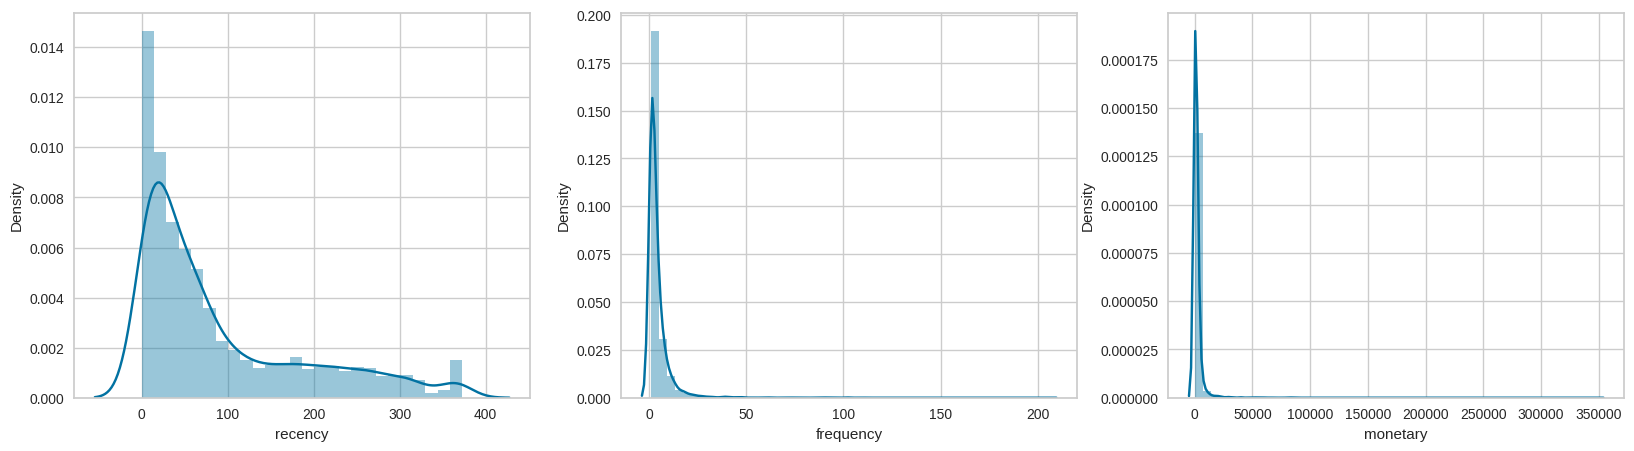

In [ ]:
#Plot data distribution
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.distplot(rfm['recency'])

plt.subplot(1,3,2)
sns.distplot(rfm['frequency'])

plt.subplot(1,3,3)
sns.distplot(rfm['monetary'])

<ipython-input-20-0ee3651b7d5e>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm['R_percentile'])
<ipython-input-20-0ee3651b7d5e>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm['F_percentile'])
<ipython-input-20-0ee3651b7d5e>:11: UserWarning: 

`distplot` is a deprecated function and w

<Axes: xlabel='M_percentile', ylabel='Density'>

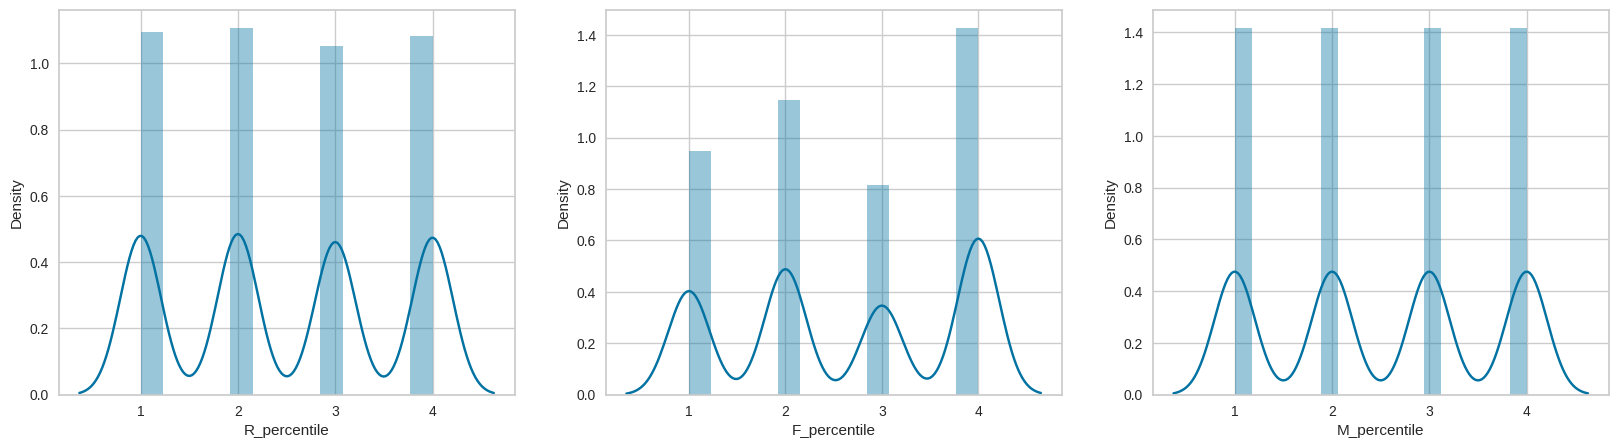

In [ ]:
#Plot data distribution
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.distplot(rfm['R_percentile'])

plt.subplot(1,3,2)
sns.distplot(rfm['F_percentile'])

plt.subplot(1,3,3)
sns.distplot(rfm['M_percentile'])

<ipython-input-21-75869cccf42e>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm['R_EqualE'])
<ipython-input-21-75869cccf42e>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm['F_EqualE'])
<ipython-input-21-75869cccf42e>:11: UserWarning: 

`distplot` is a deprecated function and will be r

<Axes: xlabel='M_EqualE', ylabel='Density'>

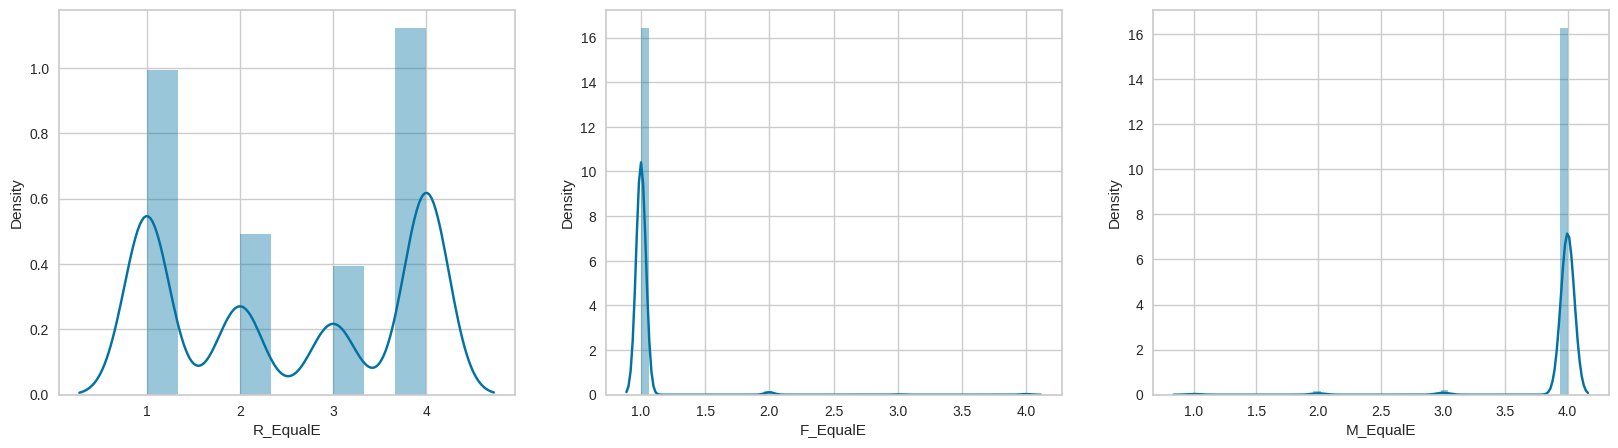

In [ ]:
#Plot data distribution
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.distplot(rfm['R_EqualE'])

plt.subplot(1,3,2)
sns.distplot(rfm['F_EqualE'])

plt.subplot(1,3,3)
sns.distplot(rfm['M_EqualE'])

<ipython-input-22-f3fd81d8f321>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm['R_Std'])
<ipython-input-22-f3fd81d8f321>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm['F_Std'])
<ipython-input-22-f3fd81d8f321>:11: UserWarning: 

`distplot` is a deprecated function and will be removed

<Axes: xlabel='M_Std', ylabel='Density'>

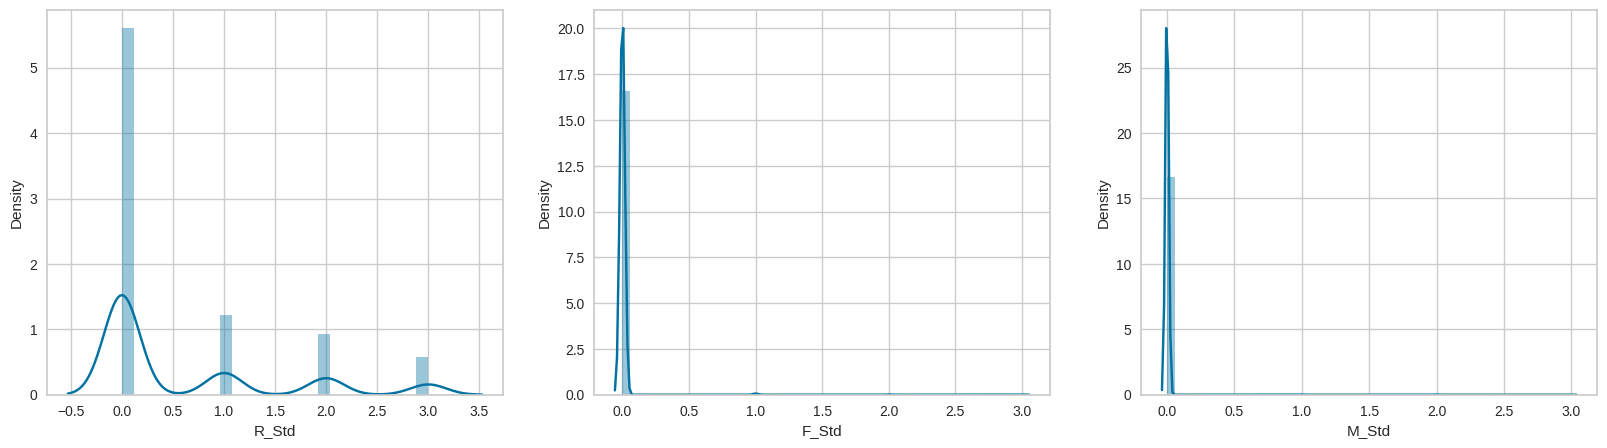

In [ ]:
#Plot data distribution
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.distplot(rfm['R_Std'])

plt.subplot(1,3,2)
sns.distplot(rfm['F_Std'])

plt.subplot(1,3,3)
sns.distplot(rfm['M_Std'])

<ipython-input-23-cf670534158c>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm['R_Weighted'])
<ipython-input-23-cf670534158c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm['F_Weighted'])
<ipython-input-23-cf670534158c>:11: UserWarning: 

`distplot` is a deprecated function and will 

<Axes: xlabel='M_Weighted', ylabel='Density'>

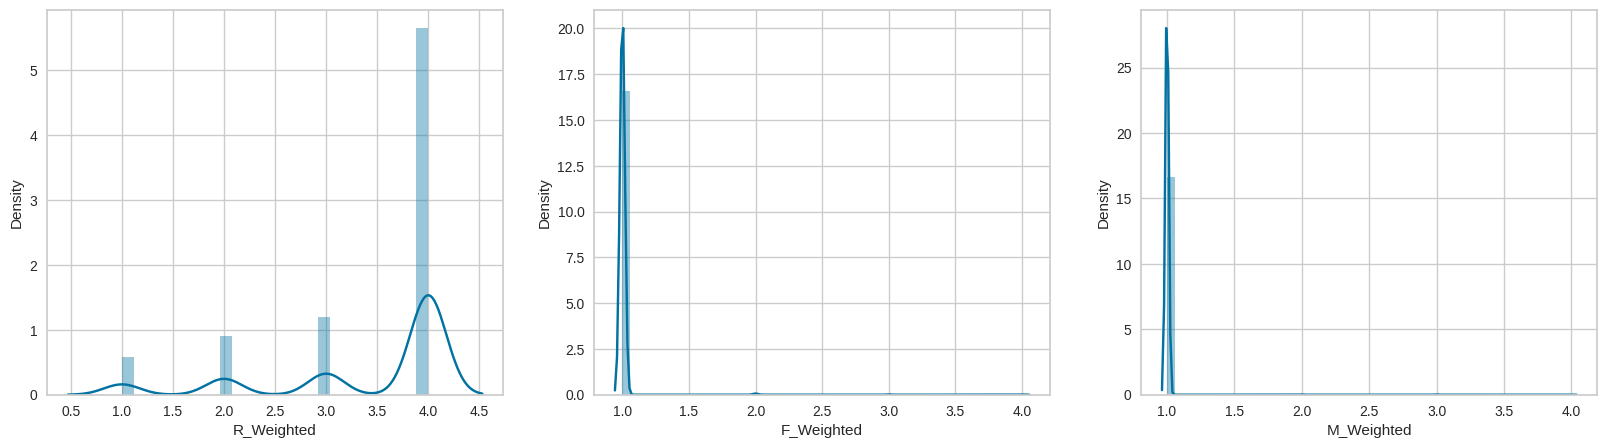

In [ ]:
#Plot data distribution
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.distplot(rfm['R_Weighted'])

plt.subplot(1,3,2)
sns.distplot(rfm['F_Weighted'])

plt.subplot(1,3,3)
sns.distplot(rfm['M_Weighted'])

**Applying K-Means Clustering for RFM Approaches**

In [ ]:
def elbow_method(rfm_scaled):
    wcss = {}  # Dictionary to store the values of WCSS (within-cluster sum of squares)

    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(rfm_scaled)

    for k in range(1, 15):
        km = KMeans(n_clusters=k, init='k-means++', max_iter=1000, random_state=20)
        km = km.fit(x_scaled)
        wcss[k] = km.inertia_

    plt.figure(figsize=(5, 3))


    # Plot graph for the WCSS values and the number of clusters
    sns.pointplot(x=list(wcss.keys()), y=list(wcss.values()))
    plt.xlabel('Number of clusters K')
    plt.ylabel('Sum of square distances')
    plt.title('Elbow method for optimal K')
    plt.show()


In [ ]:
# Create an empty DataFrame with appropriate column names
column_names = ['RFM Approach', 'Silhouette Score', 'Calinski-Harabasz Score', 'Inertia']
results_df = pd.DataFrame(columns=column_names)

def kmeans_clustering(rfm_scaled, n_clusters, label_name,approach):
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(rfm_scaled)  # Scale the data

    kmean_model = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=1000, random_state=20)
    kmean_model.fit(x_scaled)
    rfm[label_name] = kmean_model.labels_

    # Calculate silhouette score
    silhouette_avg = silhouette_score(x_scaled, kmean_model.labels_)

    # Calculate Calinski-Harabasz score
    ch_score = calinski_harabasz_score(x_scaled, kmean_model.labels_)

    # Calculate inertia
    inertia = kmean_model.inertia_

    print("Silhouette Score:", silhouette_avg)
    print("Calinski-Harabasz Score:", ch_score)
    print("Inertia:", inertia)

    global results_df
    new_row = pd.Series({
        'RFM Approach':approach,
        'Silhouette Score': silhouette_avg,
        'Calinski-Harabasz Score': ch_score,
        'Inertia': inertia
     })
    results_df = results_df.append(new_row, ignore_index=True)
    return rfm,results_df


Applying K-Means Clustering for RFM approaches and Evaluation

**Percentile Ranking Approach**

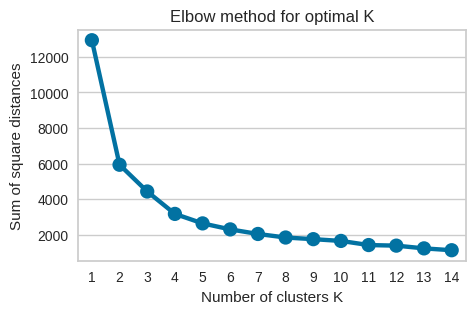

In [ ]:
#wcss stands for within cluster sum of squares
rfm_scaled=rfm[['R_percentile','F_percentile','M_percentile']]
wcss={}

elbow_method(rfm_scaled)

In [ ]:
rfm,result_df = kmeans_clustering(rfm_scaled,4,'Cluster_Percentile','Percentile Ranking Approach')

Silhouette Score: 0.43374242106408467
Calinski-Harabasz Score: 4412.295388947328
Inertia: 3176.3265643364903


**Weighted RFM Approach**

<ipython-input-24-86ead6518ee2>:9: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  km = km.fit(x_scaled)
<ipython-input-24-86ead6518ee2>:9: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (13). Possibly due to duplicate points in X.
  km = km.fit(x_scaled)
<ipython-input-24-86ead6518ee2>:9: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (14). Possibly due to duplicate points in X.
  km = km.fit(x_scaled)


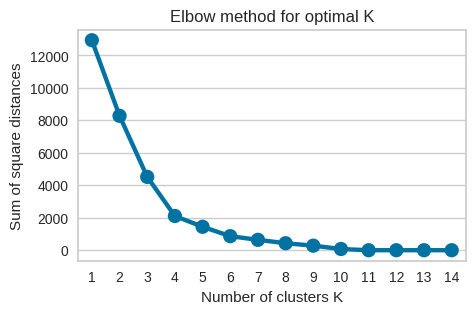

In [ ]:
#wcss stands for within cluster sum of squares
rfm_scaled=rfm[['R_Weighted','F_Weighted','M_Weighted']]
wcss={}
elbow_method(rfm_scaled)

In [ ]:
rfm,result_df = kmeans_clustering(rfm_scaled,4,'Cluster_Weighted','Weighted RFM Approach')

Silhouette Score: 0.8249266065630352
Calinski-Harabasz Score: 7376.834742230564
Inertia: 2107.845720853547


**Equal Interval Approach**

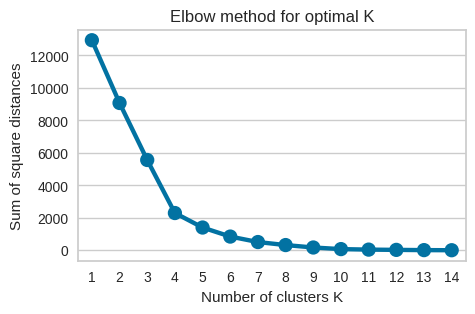

In [ ]:
#wcss stands for within cluster sum of squares
rfm_scaled  =rfm[['R_EqualE','F_EqualE','M_EqualE']]
wcss={}

elbow_method(rfm_scaled)

In [ ]:
rfm,result_df = kmeans_clustering(rfm_scaled,4,'Cluster_Equal','Equal Interval Approach')

Silhouette Score: 0.7846738853955835
Calinski-Harabasz Score: 6642.056549481743
Inertia: 2299.574889852898


**Standard Deviation Approach**

<ipython-input-24-86ead6518ee2>:9: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  km = km.fit(x_scaled)
<ipython-input-24-86ead6518ee2>:9: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (13). Possibly due to duplicate points in X.
  km = km.fit(x_scaled)
<ipython-input-24-86ead6518ee2>:9: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (14). Possibly due to duplicate points in X.
  km = km.fit(x_scaled)


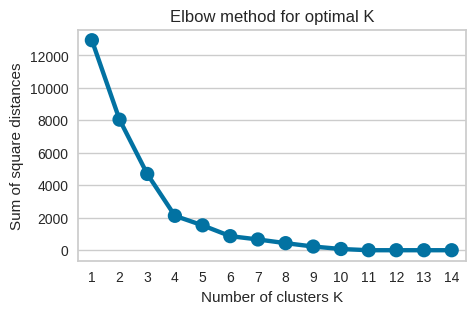

In [ ]:
#wcss stands for within cluster sum of squares
rfm_scaled  =rfm[['R_Std','F_Std','M_Std']]
wcss={}

elbow_method(rfm_scaled)

In [ ]:
rfm,result_df = kmeans_clustering(rfm_scaled,4,'Cluster_StandardDev','Standard Deviation Approach')

Silhouette Score: 0.8215758750679155
Calinski-Harabasz Score: 7329.289098386941
Inertia: 2119.279329123129


In [ ]:
rfm.head()

,recency,frequency,monetary,R_percentile,F_percentile,M_percentile,RFMGroup_Percentile,RFM_Percentile,R_EqualE,F_EqualE,...,RFMGroup_StandardDeviation,RFM_StandardDeviation,R_Weighted,F_Weighted,M_Weighted,RFM_Weighted,Cluster_Percentile,Cluster_Weighted,Cluster_Equal,Cluster_StandardDev
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,164,11,372.86,4,1,3,413,8,4,1,...,100,1,3,1,1,5.0,1,0,1,0
12347.0,2,2,1323.32,1,3,2,132,6,1,1,...,000,0,4,1,1,6.0,0,0,3,0
12348.0,73,1,222.16,3,4,4,344,11,3,1,...,000,0,4,1,1,6.0,2,0,1,0
12349.0,42,3,2671.14,2,2,1,221,5,2,1,...,000,0,4,1,1,6.0,3,0,3,0
12351.0,10,1,300.93,1,4,4,144,9,1,1,...,000,0,4,1,1,6.0,0,0,3,0


Result Evaluation

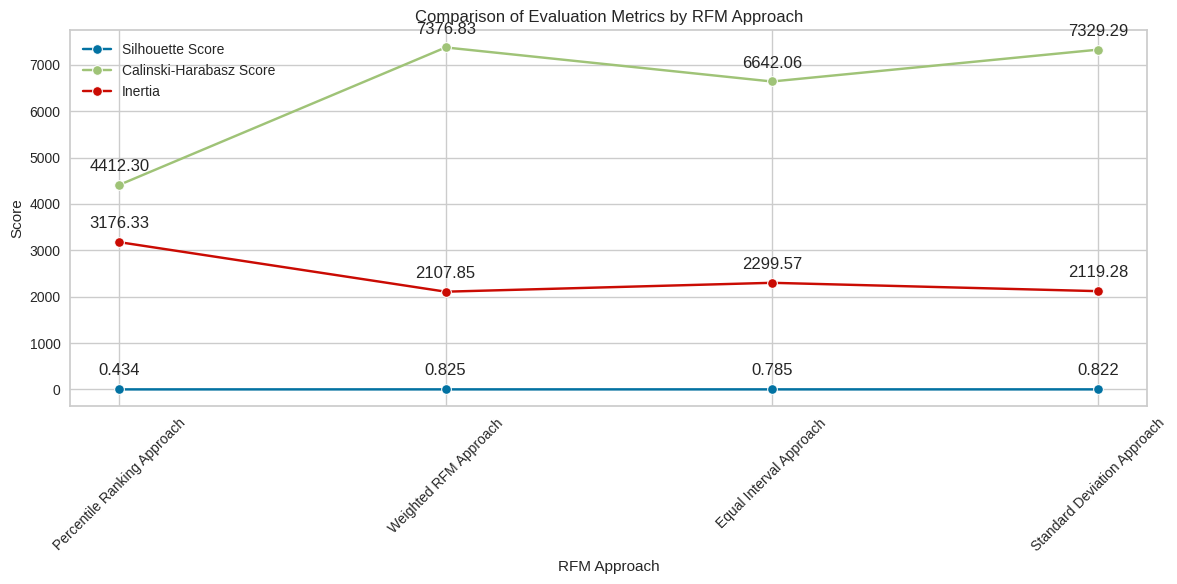

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a line chart to compare evaluation metrics by RFM Approach
plt.figure(figsize=(12, 6))

# Plot Silhouette Score
sns.lineplot(x='RFM Approach', y='Silhouette Score', data=results_df, label='Silhouette Score', marker='o')

# Plot Calinski-Harabasz Score
sns.lineplot(x='RFM Approach', y='Calinski-Harabasz Score', data=results_df, label='Calinski-Harabasz Score', marker='o')

# Plot Inertia
sns.lineplot(x='RFM Approach', y='Inertia', data=results_df, label='Inertia', marker='o')

# Add data point labels
for index, row in results_df.iterrows():
    plt.annotate(f'{row["Silhouette Score"]:.3f}', (row['RFM Approach'], row['Silhouette Score']), textcoords="offset points", xytext=(0, 10), ha='center')
    plt.annotate(f'{row["Calinski-Harabasz Score"]:.2f}', (row['RFM Approach'], row['Calinski-Harabasz Score']), textcoords="offset points", xytext=(0, 10), ha='center')
    plt.annotate(f'{row["Inertia"]:.2f}', (row['RFM Approach'], row['Inertia']), textcoords="offset points", xytext=(0, 10), ha='center')

plt.title('Comparison of Evaluation Metrics by RFM Approach')
plt.xticks(rotation=45)
plt.xlabel('RFM Approach')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
file_path1 = '/content/drive/MyDrive//Colab Notebooks/data/Online_Retail_Data/rfm_output.csv'
file_path2 = '/content/drive/MyDrive//Colab Notebooks/data/Online_Retail_Data/summary_result.csv'

rfm.to_csv(file_path1, index=True)
result_df.to_csv(file_path2, index=True)
